# Analysis of Frontpage New York Times Articles from 1996 to 2006

In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [44]:
# Load Dataset
df = pd.read_csv("US-Media-NYTimes.csv")

# Inspect the Data
display(df.head())
df.info()

,id,year,majortopic,subtopic,title,summary
0,69,1996,1,100,A Sharp Pullback,stock market slides
1,82,1996,1,100,Market Drop Grabs Notice Of Both Sides,stock market drops
2,196,1996,1,100,Flood of Cash to Mutual Funds Helped to Fuel '...,mutual funds doing well
3,335,1996,1,100,"Stocks Surge Again; Dow Exceeds 5,600",stock market
4,389,1996,1,100,ECONOMIC PULSE: The New York Region; Region's ...,NY economy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31034 entries, 0 to 31033
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31034 non-null  int64 
 1   year        31034 non-null  int64 
 2   majortopic  31034 non-null  int64 
 3   subtopic    31034 non-null  int64 
 4   title       31031 non-null  object
 5   summary     30976 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [45]:
# Cleaning the Data

# Replace Unclear Text Responses with Missing Values
df.replace({"No Response": pd.NA, "?": pd.NA, "": pd.NA}, inplace=True)

# Strip Whitespace from Strings
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert Columns to Numeric
df["id"] = pd.to_numeric(df["id"], errors="coerce")
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["majortopic"] = pd.to_numeric(df["majortopic"], errors="coerce")
df["subtopic"] = pd.to_numeric(df["subtopic"], errors="coerce")

# Standardize Text by Converting All to Lowercase
df["title"] = df["title"].str.lower()
df["summary"] = df["summary"].str.lower()

# Combine Text for Analysis
df['text'] = df['title'].fillna("") + " " + df["summary"].fillna("")

# Remove Duplicates and Missing Values After Cleaning
df = df.drop_duplicates()
df = df.dropna()

print("Remaining missing values:", df.isna().sum().sum())

Remaining missing values: 0


C:\Users\wwsc2\AppData\Local\Temp\ipykernel_22032\3705238321.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


year
1996    2944
1997    2897
1998    2955
1999    2917
2000    2919
2001    2936
2002    3055
2003    2931
2004    2589
2005    2357
2006    2473
Name: id, dtype: int64


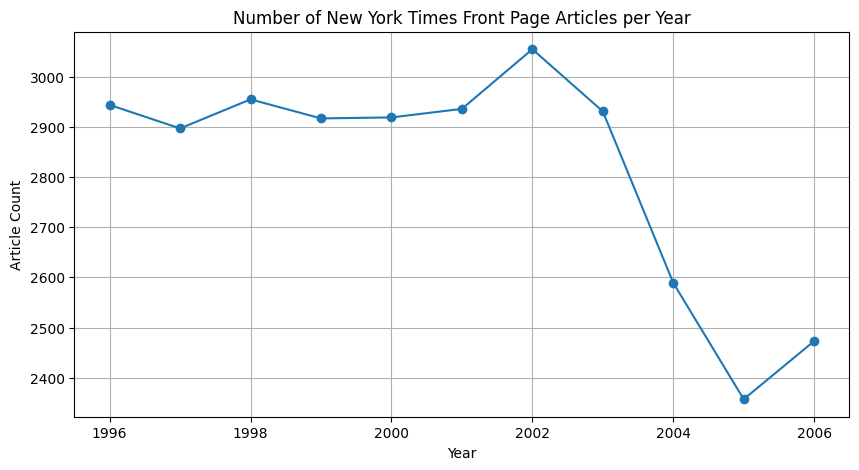

In [46]:
# Basic Descriptive Analysis

# Article Counts Per Year
articles_per_year = df.groupby("year")["id"].count()
print(articles_per_year)

plt.figure(figsize=(10,5))
plt.plot(articles_per_year.index, articles_per_year.values, marker='o')
plt.title("Number of New York Times Front Page Articles per Year")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.grid()
plt.show()

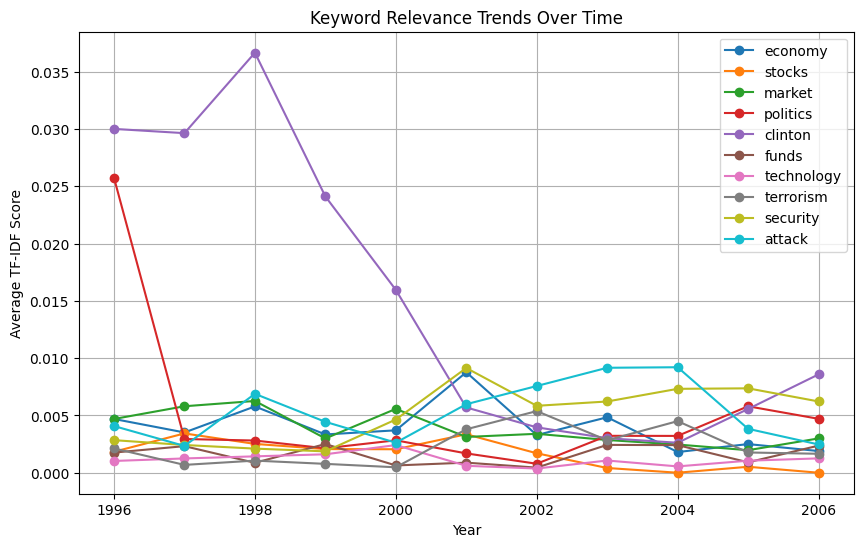

In [47]:
# TF-IDF WORD TREND ANALYSIS

# Convert Full Text into TF-IDF Representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['text'])

# Store Features
features = vectorizer.get_feature_names_out()

# Build df of TF-IDF Values
df_features = pd.DataFrame(X.toarray(), columns = features)
df_features["year"] = df["year"]

# Average TF-IDF Values Per Year
yearly_trends = df_features.groupby("year").mean()

# Choose Relevant Keywords
keywords = ["economy", "stocks", "market", "politics", "clinton", "funds", "technology", "terrorism", "security", "attack"]

# Plot Keyword Trends Over Time
plt.figure(figsize=(10,6))
for word in keywords:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Keyword Relevance Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()

Standardized Average Article Output:
election_period
Election Year        2931.5
Non-Election Year    2790.0
Name: article_count, dtype: float64


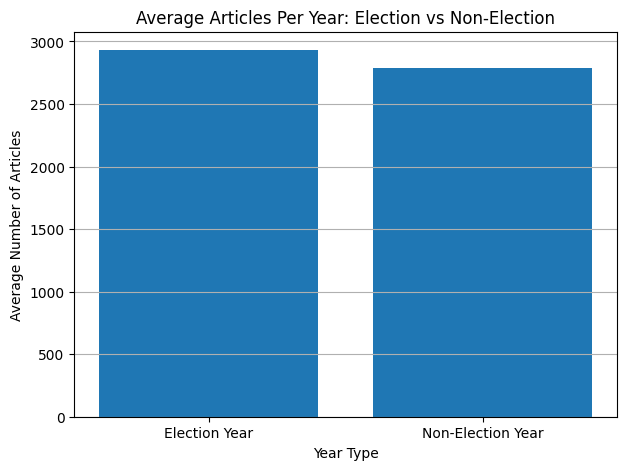

In [48]:
# Standardized Comparison of Election vs Non-Election Years

# Create a Dataframe from Yearly Counts
year_counts = pd.DataFrame({
    "year": articles_per_year.index,
    "article_count": articles_per_year.values
})

# Label Each Year as Election or Not
election_years = [1996, 2000]
year_counts["election_period"] = year_counts["year"].apply(
    lambda x: "Election Year" if x in election_years else "Non-Election Year"
)

# Compute Average Articles Per Year for Each Category
avg_counts = year_counts.groupby("election_period")["article_count"].mean()

print("Standardized Average Article Output:")
print(avg_counts)

# Bar Plot of Standardized Averages
plt.figure(figsize=(7,5))
plt.bar(avg_counts.index, avg_counts.values)

plt.title("Average Articles Per Year: Election vs Non-Election")
plt.ylabel("Average Number of Articles")
plt.xlabel("Year Type")
plt.grid(axis='y')
plt.show()


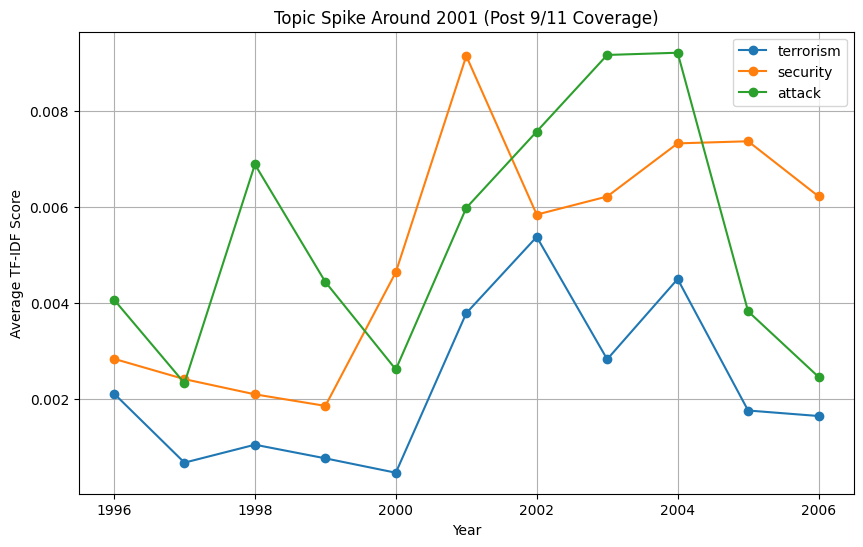

In [49]:
# Analysis of Keyword Spike After 9/11 

# Compare keyword TF-IDF before vs after 2001
before_2001 = yearly_trends.loc[yearly_trends.index < 2001]
after_2001 = yearly_trends.loc[yearly_trends.index == 2001]

# Focused plot for terrorism/security wording
focus_words = ["terrorism", "security", "attack"]

plt.figure(figsize=(10,6))
for word in focus_words:
    if word in yearly_trends:
        plt.plot(yearly_trends.index, yearly_trends[word], marker="o", label=word)

plt.title("Topic Spike Around 2001 (Post 9/11 Coverage)")
plt.xlabel("Year")
plt.ylabel("Average TF-IDF Score")
plt.legend()
plt.grid()
plt.show()

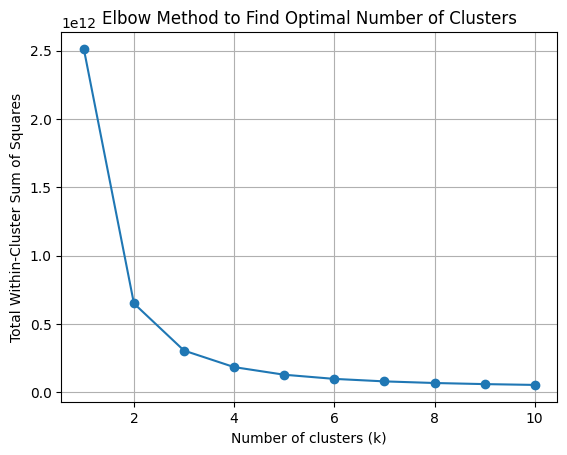

In [50]:
# Keep Only Numeric Columns
numeric_data = df.select_dtypes(include='number')

# Create a Place to Store WSS Values
wss = []

# Try Different Numbers of Clusters (k = 1 through 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=123)
    kmeans.fit(numeric_data)     # run k-means
    wss.append(kmeans.inertia_)  # inertia_ = total within-cluster error

# Plot the Elbow Curve
plt.plot(range(1, 11), wss, marker='o')
plt.title("Elbow Method to Find Optimal Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total Within-Cluster Sum of Squares")
plt.grid(True)
plt.show()

In [51]:
# Topic Clustering Using K-Means
# Purpose: Is to see if articles naturally group by themes

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

# Show Sample Articles from Each Cluster
for c in df["cluster"].unique():
    print(f"\n Cluster {c} Example Titles")
    print(df[df["cluster"]==c]["title"].head(5))


 Cluster 0 Example Titles
0                                     a sharp pullback
1               market drop grabs notice of both sides
2    flood of cash to mutual funds helped to fuel '...
3                stocks surge again; dow exceeds 5,600
4    economic pulse: the new york region; region's ...
Name: title, dtype: object

 Cluster 1 Example Titles
197    the 2000 campaign: the vice president; gore an...
234    bush's aides seek to focus efforts on the economy
239    a nation challenged: the economy; bush tries t...
246    a nation challenged: the strategy; as guns sti...
268     no strong voice is heard on bush's economic team
Name: title, dtype: object

 Cluster 2 Example Titles
969    appeals court bars klan masks; group still pla...
972     justices weaken movement backing property rights
990                         no to college admission case
991         hartford court bars imbalance in the schools
993    race can't be used to decide layoffs, appeals ...
Name: title, dtype: 

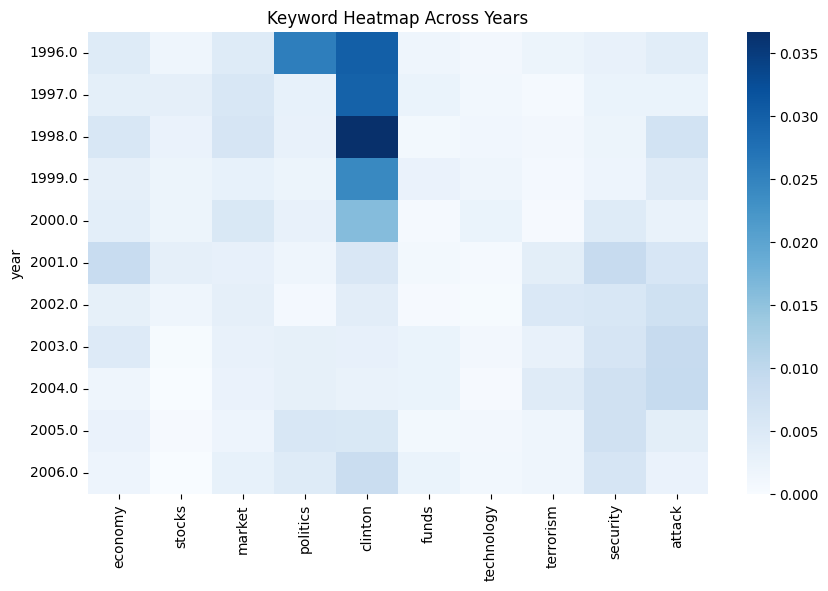

In [52]:
# Heatmap for Keyword Intensity

trend_subset = yearly_trends[[w for w in keywords if w in yearly_trends.columns]]

plt.figure(figsize=(10,6))
sns.heatmap(trend_subset, cmap="Blues", annot=False)
plt.title("Keyword Heatmap Across Years")
plt.show()

In [53]:
# Summary Outputs

print("Top 10 strongest TF-IDF words overall:")
print(yearly_trends.mean().sort_values(ascending=False).head(10))

Top 10 strongest TF-IDF words overall:
new          0.025788
iraq         0.019105
bush         0.017771
clinton      0.015071
war          0.011322
campaign     0.010880
york         0.010148
president    0.009837
election     0.009092
china        0.008991
dtype: float64
